# Application of masksembles to the 2024 PHM Data Challenge regression problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Denses

from masksembles.keras import Masksembles1D

### Load the data

In [5]:
features = pd.read_csv('data/2024_data_challenge/X_train.csv')
targets = pd.read_csv('data/2024_data_challenge/y_train.csv')

**Keep only the columns of interest**

In [19]:
features = features[['trq_measured', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng']]
targets = targets[['trq_margin']]

### Split the data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=2049)

### Scale the data

In [34]:
X_sclr = StandardScaler()
X_train_scaled = X_sclr.fit_transform(X_train)

y_sclr = StandardScaler()
y_train_scaled = y_sclr.fit_transform(y_train)

### Create and train DL model

In [50]:
%%time

batch_size = 100

input_layer = Input(shape=(7,))
layer_x = Dense(200, activation='relu')(input_layer)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(100, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
layer_x = Dense(50, activation='relu')(layer_x)
layer_x = Masksembles1D(100, 2.0)(layer_x)
output_layer = Dense(1, activation='linear')(layer_x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 93.8 ms, sys: 0 ns, total: 93.8 ms
Wall time: 77.6 ms


In [51]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               1600      
_________________________________________________________________
masksembles1d_15 (Masksemble (None, 200)               20000     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               20100     
_________________________________________________________________
masksembles1d_16 (Masksemble (None, 100)               10000     
_________________________________________________________________
dense_22 (Dense)             (None, 50)                5050      
_________________________________________________________________
masksembles1d_17 (Masksemble (None, 50)                5000

**Make sure that the train dataset size is divisible by the batch size**

In [52]:
X_train_scaled.shape[0] % batch_size

0

**The trainset size is good. Let's train**

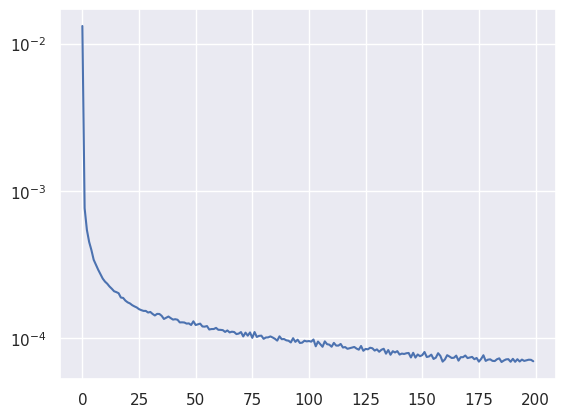

CPU times: user 52min 37s, sys: 14min 19s, total: 1h 6min 57s
Wall time: 32min 33s


In [53]:
%%time

history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=batch_size, verbose=0, shuffle=False)

plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

### Test the model

In [55]:
%%time
X_test_scaled = X_sclr.transform(X_test)
feature_stack = np.repeat(X_test_scaled, batch_size, axis=0)

y_pred = model.predict(feature_stack, batch_size=batch_size)
y_pred = y_pred.reshape(-1, batch_size)

# Unscale the data
y_pred = y_sclr.inverse_transform(y_pred)

y_pred_mean = y_pred.mean(axis=1)
y_pred_std = y_pred.std(axis=1)

In [59]:
from sklearn.metrics import mean_absolute_error

score = mean_absolute_error(y_test, y_pred_mean)
print("Mean absolute error: {}".format(score))

Mean absolute error: 0.031931203190352316


**Check to the maximum error**

In [68]:
error = y_pred_mean - y_test.values.reshape(-1)
abs_error = np.abs(error)
print("Max abs error: {}".format(abs_error.max()))

Max abs error: 3.652042403247684


In [73]:
error_gt_0p5 = abs_error > 0.5
print("# of inferences with error > 0.5: {}".format(error_gt_0p5.sum()))

# of inferences with error > 0.5: 28


### Visualize the uncertainty

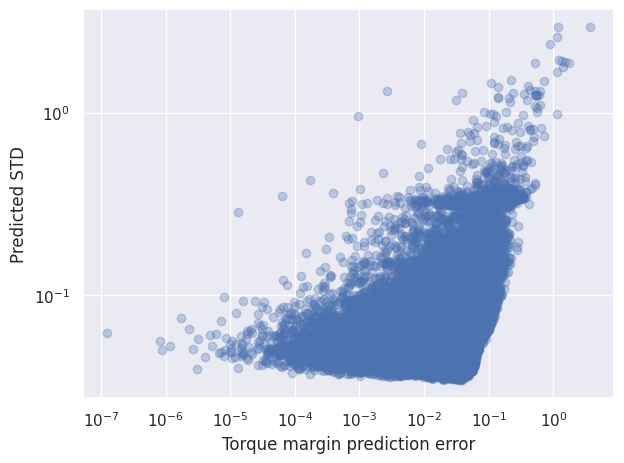

In [81]:
x = abs_error
y = y_pred_std
plt.scatter(x, y,  alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Torque margin prediction error')
plt.ylabel('Predicted STD')
plt.tight_layout()
plt.savefig('images/6.1 std_error.png', dpi=150)
plt.show()

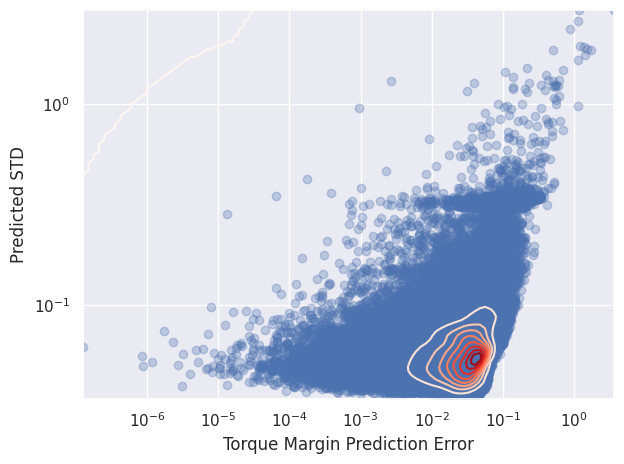

In [86]:
from scipy.stats import gaussian_kde

x = abs_error
y = y_pred_std

# Ensure data is positive to compute log and avoid issues with log scales
positive_mask = (x > 0) & (y > 0)
x = x[positive_mask]
y = y[positive_mask]

# Take the logarithm of the data for KDE computation
log_x = np.log10(x)
log_y = np.log10(y)

# Compute the KDE on the log-transformed data
xy = np.vstack([log_x, log_y])
kde = gaussian_kde(xy)

# Create a grid over the data range
x_min, x_max = log_x.min(), log_x.max()
y_min, y_max = log_y.min(), log_y.max()

# Define grid points
xi, yi = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
grid_points = np.vstack([xi.flatten(), yi.flatten()])

# Evaluate the KDE on the grid
zi = kde(grid_points)
zi = zi.reshape(xi.shape)

# Plot the density contours
plt.figure()
contour_levels = np.linspace(zi.min(), zi.max(), 10)  # Adjust the number of levels as needed
plt.contour(10**xi, 10**yi, zi, levels=contour_levels, cmap='Reds')

# Overlay the scatter plot
plt.scatter(x, y, alpha=0.3)

# Set logarithmic scales
plt.xscale('log')
plt.yscale('log')

# Labels and layout
plt.xlabel('Torque Margin Prediction Error')
plt.ylabel('Predicted STD')
plt.tight_layout()

# Save and display the plot
plt.savefig('images/6.2_std_error.png', dpi=150)
plt.show()

**Visualize the incorrect regression inference**

/tmp/ipykernel_25681/2513131060.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Prediction error')


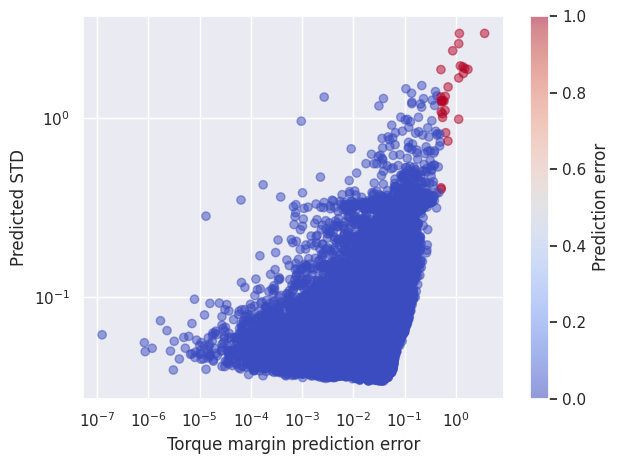

In [90]:
x = abs_error
y = y_pred_std
z = error_gt_0p5
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Prediction error')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Torque margin prediction error')
plt.ylabel('Predicted STD')
plt.tight_layout()
plt.savefig('images/6.3 std_error.png', dpi=150)
plt.show()

/tmp/ipykernel_25681/3880988684.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Prediction error')


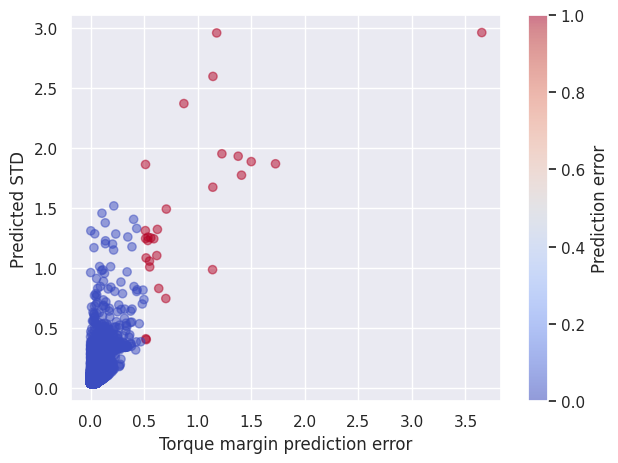

In [91]:
x = abs_error
y = y_pred_std
z = error_gt_0p5
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Prediction error')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Torque margin prediction error')
plt.ylabel('Predicted STD')
plt.tight_layout()
plt.savefig('images/6.4 std_error.png', dpi=150)
plt.show()

/tmp/ipykernel_25681/869705340.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Prediction error')


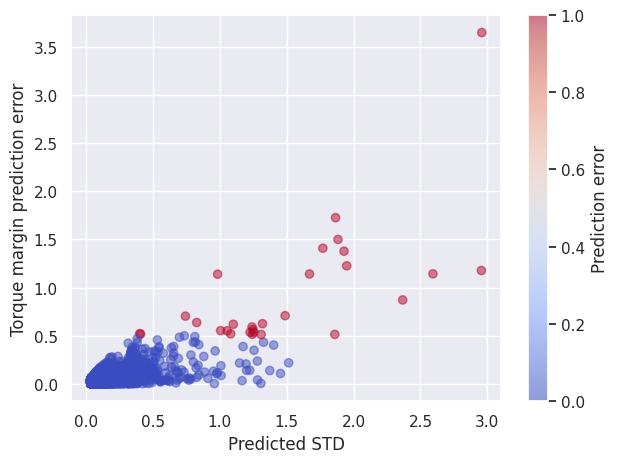

In [92]:
x = y_pred_std
y = abs_error
z = error_gt_0p5
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Prediction error')
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Torque margin prediction error')
plt.xlabel('Predicted STD')
plt.tight_layout()
#plt.savefig('images/6.4 std_error.png', dpi=150)
plt.show()

/tmp/ipykernel_25681/2658498637.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Prediction error')


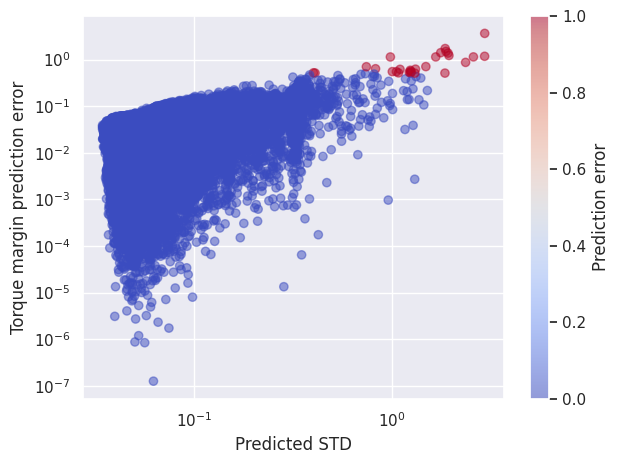

In [93]:
x = y_pred_std
y = abs_error
z = error_gt_0p5
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Prediction error')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Torque margin prediction error')
plt.xlabel('Predicted STD')
plt.tight_layout()
#plt.savefig('images/6.4 std_error.png', dpi=150)
plt.show()